In [107]:
%matplotlib inline
import bz2
import spacy
from spacy import displacy
import en_core_web_lg
import en_core_web_md
import pandas as pd
import numpy as np
import re
from collections import Counter
from nltk.tokenize import word_tokenize
import itertools as it
import json
from pprint import pprint
from tqdm import tqdm_pandas, tqdm_notebook, tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from stanfordcorenlp import StanfordCoreNLP
from nltk.tree import Tree
from IPython.lib import backgroundjobs as bg

pd.set_option('display.max_colwidth', 500)
tqdm_notebook()

0it [00:00, ?it/s]

In [641]:
tqdm.pandas()

## Description
This notebook covers the task of classication of end of sentences in run-on sentences. From this data posts with less then 2 sentences was removed. Also from this data collection of ngrams were generated. The ngrams were collected into `rocksdb` database, so I won't need to load in memory and it will have a sufficent search performance. The next step was do feature extraction. Features:

* Token text
* Next token text
* Prev token text
* Token POS
* Next token POS
* Prev token POS
* Is current token titled
* Is next token titled
* Frequency of 2gram `<token> .`
* Frequency of 2gram `. <token+1>`
* Frequency of 3gram `<token> . <token+1>`
* Frequency of 3gram `<token-1> <token> .`
* Nearest common parent in constituency tree between `<token>` and `<token+1>`


**Dataset**:  Usenet posts from http://www.psych.ualberta.ca/~westburylab/downloads/usenetcorpus.download.html

**Data size**: 164000 posts with more than 1 sentences in each

**Number on ngrams collected**: *pyrocksdb doesn't allow to estimate number of rows*

## Feature extraction
We will start with fetching some features from our dataset

In [21]:
snlp = StanfordCoreNLP('http://localhost', port=9000)

In [22]:
nlp_full = en_core_web_lg.load()
nlp_sent = en_core_web_lg.load(disable=['parser', 'ner', 'textcat', 'tagger'])
nlp_sent.add_pipe(nlp_sent.create_pipe('sentencizer'))

Function for concating sentences

In [20]:
def concat_sents(sents):
    tok_sents = [nlp_sent(sent) for sent in sents]
    new_sent = sents[0][0:-1]
    for i, sent in enumerate(sents[1:-1]):
        if (np.random.choice([0, 1])) == 0:
            new_sent += " " + sent[0].lower()
        else:
            new_sent += " " + sent[0]
        new_sent += sent[1:-1]
    if np.random.choice([0, 1]) == 0:
        new_sent += " " + sents[-1][0].lower()
    else:
        new_sent += " " + sents[-1][0]
    new_sent += sents[-1][1:]
    
    ends = [len(sent)-1 for sent in sents[:-1]]
    ends[0] -= 1
    return (new_sent, ends)

In [53]:
def extract_features(features, doc, ctree, i):
    feats = {}
    for name, f in features.items():
        feats[name] = f({'doc': doc, 'ctree': ctree}, i)
    return feats

In [213]:
def extract_features_for_all(f, features, limit=2, skip=0):
    items = list(it.islice(f, skip, limit+skip))
    docs_features = []
    docs_labels = []
    docs = []
    for item in tqdm_notebook(items):
        sents = json.loads(item.decode('utf-8'))
        (sent, ends) = concat_sents(sents)
        doc = nlp_full(sent)
        try:
            stree = snlp.parse(sent)
        except json.JSONDecodeError:
            stree = '(S)'
        ctree = Tree.fromstring(stree)
        N = len(doc)
        for i in range(N):
            tok = doc[i]
            feats = extract_features(features, doc, ctree, i)
            if any([(tok.idx <= end) and (end < (tok.idx + len(tok.text))) for end in ends]):
                docs_labels.append(True)
            else:
                docs_labels.append(False)
            
            docs_features.append(feats)
            docs.append(tok.text.lower())
    return (docs_features, docs_labels, docs)

In [134]:
def evaluate(est, X, y):
    f1_pos = make_scorer(f1_score, labels=[1])
    prec_pos = make_scorer(precision_score, labels=[1])
    rec_pos = make_scorer(recall_score, labels=[1])
    return cross_validate(pipe, X, y, 
                          scoring={'f1_pos': f1_pos, 'prec_pos': prec_pos, 'rec_pos': rec_pos},
                          return_train_score=True)

In [18]:
features_set1 = {
    'text': lambda e,i: e['doc'][i].text.lower(),
    'istitle': lambda e,i: e['doc'][i].is_title,
    'pos': lambda e,i: e['doc'][i].pos_,
    'text-1': lambda e,i: e['doc'][i-1].text if i-1 >= 0 else '<S>',
    'pos-1': lambda e,i: e['doc'][i-1].pos_ if i-1 >= 0 else 'NONE',
    'text+1': lambda e,i: e['doc'][i+1].text if i+1 < len(e['doc']) else '</S>',
    'istitle+1': lambda e,i: e['doc'][i+1].is_title if i+1 < len(e['doc']) else False,
    'pos+1': lambda e,i: e['doc'][i+1].pos_ if i+1 < len(e['doc']) else 'NONE'
}

In [23]:
with bz2.open('train.txt.bz2') as f:
    (doc_features1, doc_labels1, docs1) = extract_features_for_all(f, features_set1, limit=1000)

100%|██████████| 1000/1000 [00:22<00:00, 44.07it/s]


In [48]:
pd.DataFrame(doc_features1).assign(label = doc_labels1).to_csv('features1.csv.bz2', compression='bz2')

In [24]:
pipe = Pipeline([
    ('vectorizer', DictVectorizer()),
    ('classifier', LogisticRegression())
])
evaluate(pipe, doc_features1, doc_labels1)

{'fit_time': array([0.55368495, 0.49376702, 0.49124098]),
 'score_time': array([0.47720385, 0.47927308, 0.48680234]),
 'test_f1_pos': array([0.22794118, 0.21308411, 0.27272727]),
 'test_prec_pos': array([0.61386139, 0.61956522, 0.6       ]),
 'test_rec_pos': array([0.13995485, 0.12866817, 0.17647059]),
 'train_f1_pos': array([0.43463497, 0.42942686, 0.42222222]),
 'train_prec_pos': array([0.87372014, 0.88380282, 0.86971831]),
 'train_rec_pos': array([0.28926554, 0.28361582, 0.27878104])}

## Feature set #2

Load ngrams

In [104]:
import rocksdb
db2 = rocksdb.DB('ngrams2/2grams.db', rocksdb.Options(), read_only=True)
db3 = rocksdb.DB('ngrams2/3grams.db', rocksdb.Options(), read_only=True)
def find2gram(ngram):
    res = db2.get(ngram.lower().encode('utf-8'))
    if res:
        return int(res.decode('utf-8'))
    else:
        return 0
    
def find3gram(ngram):  
    res = db3.get(ngram.lower().encode('utf-8'))
    if res:
        return int(res.decode('utf-8'))
    else:
        return 0

finds common ancestor in constituency tree:

In [103]:
def common_ancestor(tree, i, j):
    max = len(tree.leaves())
    if (i >= max) or (j >= max):
        return 'NONE'
    tp1 = tree.leaf_treeposition(i)
    tp2 = tree.leaf_treeposition(j)
    atp = []
    for tpi,tpj in zip(tp1, tp2):
        if tpi == tpj:
            atp.append(tpi)
        else:
            break
    return tree[tuple(atp)].label()

In [101]:
features_set2 = {
    'word_._freq': 
    lambda e,i: find2gram(" ".join([e['doc'][i].text,'.'])),
    
    '._word+1_freq':
    lambda e,i: find2gram(" ".join(['.', e['doc'][i+1].text])) if i+1<len(e['doc']) else 0,
    
    'word_._word+1_freq': 
    lambda e,i: find3gram(" ".join([e['doc'][i].text, ".", e['doc'][i+1].text])) if i+1<len(e['doc']) else 0,
    
    'word-1_word_._freq': 
    lambda e,i: find3gram(" ".join([e['doc'][i-1].text if i-1>0 else '<S>', e['doc'][i].text,'.'])),
    
    'common_ancestor': 
    lambda e,i: common_ancestor(e['ctree'], i, i+1)
}
features_set2.update(features_set1)

In [214]:
with bz2.open('train.txt.bz2') as f:
    (doc_features2, doc_labels2, docs2) = extract_features_for_all(f, features_set2, skip=0, limit=25000)

In [215]:
pd.DataFrame(doc_features2).assign(label = doc_labels2).to_csv('features00.csv.bz2', compression='bz2')

In [221]:
docs_all = pd.concat([pd.read_csv('features3.csv.bz2', compression='bz2', index_col=0),
                      pd.read_csv('features4.csv.bz2', compression='bz2', index_col=0),
                      pd.read_csv('features5.csv.bz2', compression='bz2', index_col=0),
                      pd.read_csv('features6.csv.bz2', compression='bz2', index_col=0),
                      pd.read_csv('features7.csv.bz2', compression='bz2', index_col=0)])

docs_all = docs_all.dropna().reset_index(drop=True)
docs_labels_all = docs_all['label']
docs_features_all = docs_all.copy()
del docs_features_all['label']

In [194]:
pipe = Pipeline([
    ('vectorizer', DictVectorizer()),
    ('classifier', LogisticRegression())
])
evaluate(pipe, docs_features_all.to_dict('records'), docs_labels_all)

{'fit_time': array([15.46146894, 16.18705082, 14.81109309]),
 'score_time': array([6.49365211, 6.51948905, 6.47504616]),
 'test_f1_pos': array([0.       , 0.0466563, 0.       ]),
 'test_prec_pos': array([0.        , 0.67741935, 0.        ]),
 'test_rec_pos': array([0.        , 0.02416015, 0.        ]),
 'train_f1_pos': array([0.      , 0.045898, 0.      ]),
 'train_prec_pos': array([0.        , 0.63109756, 0.        ]),
 'train_rec_pos': array([0.      , 0.023815, 0.      ])}

#### Is it good to feed more data into classifier?

/Users/serhiinechyporhuk/.local/share/virtualenvs/SerhiiNechyporchuk-Ib9yWLjX/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/serhiinechyporhuk/.local/share/virtualenvs/SerhiiNechyporchuk-Ib9yWLjX/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/serhiinechyporhuk/.local/share/virtualenvs/SerhiiNechyporchuk-Ib9yWLjX/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/serhiinechyporhuk/.local/share/virtualenvs/SerhiiNechyporchuk-Ib9yWLjX/lib/python3.6/site-packages/sklearn/metrics/classi

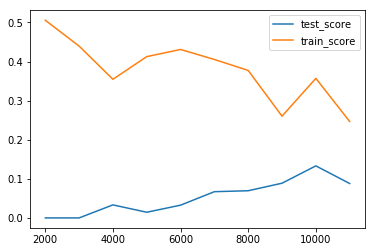

In [226]:
results = []
limits = [2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000]
for limit in tqdm_notebook(limits):
    pipe = Pipeline([
        ('vectorizer', DictVectorizer()),
        ('classifier', LogisticRegression())
    ])
    res = evaluate(pipe, docs_features_all[:limit].to_dict('records'), docs_labels_all[:limit])
    results.append(res)
    
pd.DataFrame([{'test_score': np.mean(result['test_f1_pos']),
               'train_score': np.mean(result['train_f1_pos'])}
              for result in results],
             index=limits).plot()

It is clear that adding more examples improves test score. 

### Let's play with resampled data

In [253]:
docs_all['label'].value_counts()/len(docs_all)

False    0.969362
True     0.030638
Name: label, dtype: float64

In [254]:
def resample(df, ratio):
    n = int(df['label'].sum()/ratio)
    negs = df[df['label'] == 0].sample(n=n)
    return pd.concat([df[df['label'] == 1], negs]).sample(n=np.sum(df['label'] == 1)+n)

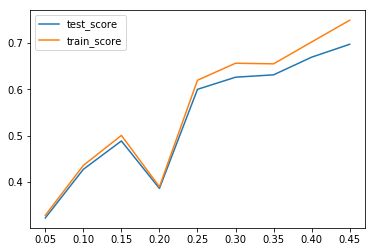

In [257]:
results = []
ratios = np.arange(0.05, 0.5, 0.05)
for ratio in tqdm_notebook(ratios):
    feats = resample(docs_all, ratio)
    labels = feats['label']
    del feats['label']
    pipe = Pipeline([
        ('vectorizer', DictVectorizer()),
        ('classifier', LogisticRegression())
    ])
    res = evaluate(pipe, feats.to_dict('records'), labels)
    results.append(res)
pd.DataFrame([{'test_score': np.mean(result['test_f1_pos']),
               'train_score': np.mean(result['train_f1_pos'])}
              for result in results],
             index=ratios).plot()

Looks like test score is growing with number of examples

In [250]:
from sklearn.manifold import TSNE

dv = DictVectorizer()
subdocs = resample(docs_all, 0.35)
subdocs_labels = subdocs['label']
del subdocs['label']
features = dv.fit_transform(subdocs.iloc[:2000].to_dict('records')).toarray()
tsne = TSNE(verbose=0)
twod = tsne.fit_transform(features)

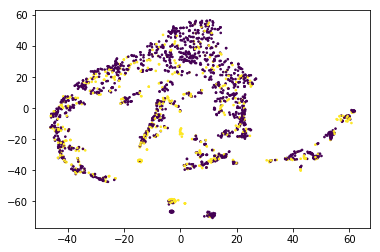

In [251]:
plt.scatter(twod[:,0], twod[:, 1], c=subdocs_labels[:2000], s=2.5)

That data doesn't look like linear seperable. But will see, high dimenstion spaces are weird 

### Load test set

In [76]:
nlp_test = spacy.load('en_core_web_lg')

In [130]:
test_features = []
test_labels = []
with open('../../../../tasks/07-language-as-sequence/run-on-test.json') as f:
    for s in json.load(f):
        doc = spacy.tokens.Doc(nlp_test.vocab, words=[t[0] for t in s])
        nlp_test.tagger(doc)
        nlp_test.parser(doc)
        ctree = Tree.fromstring('(S)')
        for i in range(len(doc)):
            feats = extract_features(features_set1, doc, ctree, i)
            test_features.append(feats)
        sent_labels = [t[1] for t in s]
        test_labels += sent_labels

In [131]:
len(test_features),len(test_labels)

(4697, 4697)

In [262]:
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(pipe, {'classifier__C': 10.**-np.arange(-5, 2)}, return_train_score=True, cv=5)
gs.fit(docs_all.to_dict('records'), labels_all)

NameError: name 'labels_all' is not defined

In [168]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classifier__C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,2.344761,0.080778,0.791287,0.977566,100000,{'classifier__C': 100000.0},7,0.785954,0.977999,0.801894,...,0.789069,0.978148,0.788871,0.974399,0.790647,0.977063,0.406037,0.003396,0.005516,0.001889
1,2.337905,0.078938,0.798982,0.976481,10000,{'classifier__C': 10000.0},5,0.791083,0.977851,0.821231,...,0.790055,0.977803,0.793015,0.974695,0.799526,0.975583,0.428298,0.001879,0.011602,0.001234
2,2.598817,0.080910,0.792431,0.977408,1000,{'classifier__C': 1000.0},6,0.790491,0.977802,0.805051,...,0.789266,0.978099,0.781768,0.974991,0.795580,0.975879,0.490814,0.001781,0.007703,0.001844
3,2.104485,0.082299,0.802415,0.974281,100,{'classifier__C': 100.0},4,0.796410,0.976667,0.807616,...,0.798737,0.976964,0.789463,0.974695,0.819850,0.963301,0.543158,0.004128,0.010472,0.005724
4,1.499572,0.077637,0.818831,0.970266,10,{'classifier__C': 10.0},3,0.816729,0.970353,0.827940,...,0.819653,0.969615,0.811365,0.969121,0.818469,0.969417,0.188858,0.003409,0.005365,0.001341
5,1.079643,0.082667,0.833669,0.903496,1,{'classifier__C': 1.0},1,0.832117,0.905189,0.837609,...,0.840568,0.903320,0.825770,0.903172,0.832281,0.901001,0.077455,0.007722,0.005096,0.001478
6,0.676354,0.080421,0.829920,0.844550,0.1,{'classifier__C': 0.1},2,0.830144,0.844712,0.832873,...,0.832478,0.843338,0.824191,0.847087,0.829913,0.844374,0.049006,0.001758,0.003103,0.001391


In [259]:
pipe = Pipeline([
    ('vectorizer', DictVectorizer()),
    ('classifier', LogisticRegression())
])

#pipe.fit(doc_features2, doc_labels2)
feats = resample(docs_all, 0.40)
labels = feats['label']
del feats['label']
pipe.fit(feats.to_dict('records'), labels)
evaluate(pipe, feats.to_dict('records'), labels)

{'fit_time': array([ 9.67538714, 14.0169704 ,  7.92578793]),
 'score_time': array([1.91198611, 1.93295979, 2.09183407]),
 'test_f1_pos': array([0.68902213, 0.69330511, 0.66901142]),
 'test_prec_pos': array([0.81683231, 0.81895474, 0.81513713]),
 'test_rec_pos': array([0.59579739, 0.60108287, 0.5673121 ]),
 'train_f1_pos': array([0.74876329, 0.76752595, 0.70427858]),
 'train_prec_pos': array([0.8777298 , 0.88617251, 0.85540984]),
 'train_rec_pos': array([0.65284023, 0.67689837, 0.59853177])}

In [260]:
f1_score(test_labels, pipe.predict(test_features))

0.5327868852459016

## Conslusions
I have received `f1` score equals to `0.532`. It's not so good, but I see that feeding more data into classifier will make it better, so this is #1 to try. Its looks like adding more feature won't do the tricks, beacause we already have a good train score (`73%`). I saw that resempling improves validation score, but I'm afraid that I had to train on resampled dataset, but test on the skewed, so maybe this results with cv on upsampled data are not representative. 